# Controlling Back Propagation of Gradients


## Step 0: Imports


In [ ]:
!!pip install torchviz

['Requirement already satisfied: torchviz in /usr/local/lib/python3.11/dist-packages (0.0.3)',
 'Requirement already satisfied: torch in /usr/local/lib/python3.11/dist-packages (from torchviz) (2.6.0+cu124)',
 'Requirement already satisfied: graphviz in /usr/local/lib/python3.11/dist-packages (from torchviz) (0.20.3)',
 'Requirement already satisfied: filelock in /usr/local/lib/python3.11/dist-packages (from torch->torchviz) (3.18.0)',
 'Requirement already satisfied: typing-extensions>=4.10.0 in /usr/local/lib/python3.11/dist-packages (from torch->torchviz) (4.13.2)',
 'Requirement already satisfied: networkx in /usr/local/lib/python3.11/dist-packages (from torch->torchviz) (3.4.2)',
 'Requirement already satisfied: jinja2 in /usr/local/lib/python3.11/dist-packages (from torch->torchviz) (3.1.6)',
 'Requirement already satisfied: fsspec in /usr/local/lib/python3.11/dist-packages (from torch->torchviz) (2025.3.2)',
 'Requirement already satisfied: nvidia-cuda-nvrtc-cu12==12.4.127 in /u

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot
import graphviz

# To visualize the computation graph, you need to install torchviz:
!pip install torchviz
try:
    from torchviz import make_dot
    has_torchviz = True
except ImportError:
    has_torchviz = False
    print("torchviz is not installed.  Install it with 'pip install torchviz' to see computation graphs.")

## Step 1: Using `.detach()` to Stop Gradient Flow

Original tensor a: tensor([2.], requires_grad=True)
Tensor b (a * 3): tensor([6.], grad_fn=<MulBackward0>)

--- Visualizing Graph BEFORE detach ---


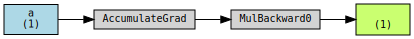

Computation graph before detach (displayed above)

Tensor c (b.detach()): tensor([6.]), requires_grad for c: False
out1 (c * 2): tensor([12.])
out2 (b * 4): tensor([24.], grad_fn=<MulBackward0>)
L (out1 + out2): tensor([36.], grad_fn=<AddBackward0>)

--- Visualizing Graph AFTER detach ---


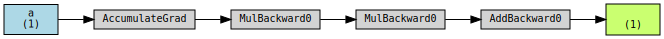

Computation graph after detach (displayed above)

Gradient of a (a.grad): tensor([12.])


In [ ]:
import torch
from torchviz import make_dot
import graphviz

# Initial tensor requiring gradients
a = torch.tensor([2.0], requires_grad=True)
print(f"Original tensor a: {a}")

# First operation connected to 'a'
b = a * 3
print(f"Tensor b (a * 3): {b}")

print("\n--- Visualizing Graph BEFORE detach ---")
dot_before = make_dot(b, params={'a': a})
dot_before.attr(rankdir='LR')
display(dot_before)
print("Computation graph before detach (displayed above)")


# Detach 'b' to create 'c'.
c = b.detach()
print(f"\nTensor c (b.detach()): {c}, requires_grad for c: {c.requires_grad}") # ADD \n for better spacing

# Note: 'c' could have its own requires_grad set to True (e.g., c.requires_grad_(True))
# for subsequent operations, but gradients would only flow back to 'c', not through to 'a'.
# This is not done here to keep the example focused.

# Operation using the detached tensor 'c'
out1 = c * 2
print(f"out1 (c * 2): {out1}")

# Operation using the original tensor 'b' (still connected to 'a')
out2 = b * 4
print(f"out2 (b * 4): {out2}")

# Combine outputs for the final 'loss'
L = out1 + out2
print(f"L (out1 + out2): {L}")

# Visualize the graph *after* detach
print("\n--- Visualizing Graph AFTER detach ---")
dot_after = make_dot(L, params={'a': a})
dot_after.attr(rankdir='LR')
display(dot_after)
print("Computation graph after detach (displayed above)")

# Backpropagate
L.backward()

# Check the gradient of 'a'
print(f"\nGradient of a (a.grad): {a.grad}") # ADD \n for better spacing

## Step 2: "Freezing" Parameters with `requires_grad = False`


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create a simple linear model
# This model has two learnable parts: 'weight' and 'bias'.
# By default, PyTorch knows we want to train (learn) these,
# so it sets their 'requires_grad' property to True.
model = nn.Linear(in_features=3, out_features=2)
print("Initial model parameters:")
print(f"  model.weight: {model.weight.data}")
print(f"  model.bias: {model.bias.data}\n")

# Confirm both weight and bias are set to be updated initially
print(f"Original requires_grad for model.weight: {model.weight.requires_grad}") # True, meaning it will be updated
print(f"Original requires_grad for model.bias: {model.bias.requires_grad}\n")     # True, meaning it will be updated

# --- FREEZING A PARAMETER ---
# We want to "freeze" the 'weight' parameter.
# This means we DO NOT want its value to change during training.
# Why freeze? Imagine using a pre-trained model; you might want to keep its
# learned features fixed and only train new layers.
model.weight.requires_grad = False
# By setting requires_grad to False, we tell PyTorch:
# 1. DO NOT calculate gradients for 'model.weight' during backpropagation.
# 2. As a result, the optimizer will skip updating 'model.weight'.
print(f"New requires_grad for model.weight: {model.weight.requires_grad}") # Now False (frozen)
print(f"requires_grad for model.bias remains: {model.bias.requires_grad}\n") # Still True (will be updated)

# Store original parameter values to check for changes later
original_weight = model.weight.data.clone()
original_bias = model.bias.data.clone()

# Dummy input and target data
dummy_input = torch.randn(4, 3)
dummy_target = torch.randn(4, 2)

# Optimizer: This is what adjusts our model's learnable parameters.
# It receives ALL parameters from the model.
# Crucially, the optimizer will only update parameters that have gradients computed
# (i.e., those where 'requires_grad' is True and thus a gradient is available).
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# --- One step of "training" ---
optimizer.zero_grad()       # Clear any old gradients
output = model(dummy_input) # Pass data through the model (forward pass)
loss = nn.MSELoss()(output, dummy_target) # Calculate how "wrong" our model is (loss)
loss.backward()             # Compute gradients (backward pass)
                            # PyTorch calculates how much each 'requires_grad=True'
                            # parameter needs to change to reduce the loss.
                            # Since 'model.weight.requires_grad' is False, NO gradient
                            # is computed for it. 'model.bias' gets a gradient.

# Check the computed gradients
print("Gradients after backward pass:")
# No gradient for weight because it was frozen (requires_grad=False)
print(f"  Gradient for model.weight: {model.weight.grad}")
# A gradient exists for bias because it's still trainable (requires_grad=True)
print(f"  Gradient for model.bias: {model.bias.grad}\n")

optimizer.step()            # Optimizer uses the gradients to update parameters.
                            # It only updates parameters for which gradients were computed.

# Check if parameters actually changed
print("Parameters after optimizer step:")
print(f"  model.weight: {model.weight.data}")
print(f"  model.bias: {model.bias.data}\n")

weight_updated = not torch.equal(model.weight.data, original_weight)
bias_updated = not torch.equal(model.bias.data, original_bias)

print(f"Was model.weight updated? {weight_updated}") # Expected: False (it was frozen!)
print(f"Was model.bias updated? {bias_updated}")     # Expected: True (it was trainable!)

Initial model parameters:
  model.weight: tensor([[ 0.3181,  0.4520, -0.5551],
        [-0.0733,  0.3091, -0.4354]])
  model.bias: tensor([-0.2679, -0.3763])

Original requires_grad for model.weight: True
Original requires_grad for model.bias: True

New requires_grad for model.weight: False
requires_grad for model.bias remains: True

Gradients after backward pass:
  Gradient for model.weight: None
  Gradient for model.bias: tensor([0.5126, 0.2573])

Parameters after optimizer step:
  model.weight: tensor([[ 0.3181,  0.4520, -0.5551],
        [-0.0733,  0.3091, -0.4354]])
  model.bias: tensor([-0.3192, -0.4020])

Was model.weight updated? False
Was model.bias updated? True
